In [2]:
import mpmath as mpm
import numpy as np
def Chbshv_poly(L, x): # Lth Chebyshev polynomial of the first kind
    return mpm.cos(L * mpm.acos(x))
    
def Hn(n):
    # Hadamard Gate H^{\otimes n}
    # Return the numpy array
    H = 1/np.sqrt(2) * np.array([[1,1],[1,-1]])
    Hn = H*1
    for i in range(n-1):
        Hn = np.kron(Hn, H)
    return Hn


def In(n):
    # 2-by-2 Identity gate I^{\otimes n}
    # Reutrn the numpy array
    I = np.array([[1,0],[0,1]])
    In = I*1
    for i in range(n-1):
        In = np.kron(In, I)
    return In

def checkUnitary(A):
    # Check if a given matrix A is unitary
    # Return
    nrow = A.shape[0]
    return np.linalg.norm(A.dot(A.conj().T) - In(int(np.log2(nrow))))

In [3]:
# Input parameters for the Fixed-Point Grover's search
n = 2 # Number of qubits 
indices_to_mark = 3 # An interger from 0 to 2**n

itr = 1 # Number of iterations
d = mpm.sqrt(0.2) # Success probability P_L >= 1 - d^2 if lambda = len(indices_to_mark)/2**n >= omega

In [4]:
# Compute the rest of parameters
l = itr
L = 2*l+1

gamma_inverse = Chbshv_poly(1/L, 1/d)
omega = 1 - Chbshv_poly(1/L, 1/d)**(-2)

alpha =  mpm.zeros(1,l)
beta = mpm.zeros(1,l)
for i in range(l): # use i instead of j since python use 1j for sqrt(-1)
    alpha[i] = 2*mpm.acot(mpm.tan(2*mpm.pi*(i+1)/L) * mpm.sqrt(1-1/gamma_inverse**2))
    beta[l-(i+1)+1-1] = -alpha[i]
    
# Convert to numpy
gamma_inverse = np.array([gamma_inverse], dtype=complex)[0]
omega = np.array([omega], dtype=complex)[0]
alpha = np.array(alpha.tolist()[0], dtype=complex)
beta = np.array(beta.tolist()[0], dtype=complex)

print("gamma^-1 = ", gamma_inverse)
print("lambda = ", 1/2**n)
print("Omega = ", omega)
print("alpha", alpha)
print("beta", beta)

gamma^-1 =  (1.118033988749895+0j)
lambda =  0.25
Omega =  (0.20000000000000007+0j)
alpha [-1.82347658+0.j]
beta [1.82347658+0.j]


# Compute S_s(alpha) and S_t(beta), simulate the process using matrices and vectors (assuming we know the target state)

In [5]:
# Simulate the computation process
# Start with |0...0> as default to many quantum computing platforms
ket0 = np.zeros((2**n, 1))
ket0[0] = 1

# Initilize the state with matrix A, where |s> = A|0...0>
A = Hn(n) # Use H^{\otimes n} to initilize the state
kets = np.dot(A, ket0) #Compute |s>

# Compute |t>, the target state
kett = np.zeros((2**n, 1))
kett[indices_to_mark] = 1 

# State Grover iterations
starting_state = kets
for i in range(itr):
    a = alpha[i] # selected alpha
    b = beta[i] # selected beta
    
    # Construct S_t(beta)
    Sbeta = In(n) - (1-np.exp(1j*b))*np.dot(kett,kett.T)
    if checkUnitary(Sbeta) > 1e-8:
        print("Potential non-unitary S_beta at itr {:d}, norm of difference is {:.4g}".format(i, checkUnitary(Sbeta)))
    # Construct S_s(alpha)
    Salpha = In(n) - (1-np.exp(-1j*a))*np.dot(kets,kets.T)
    if checkUnitary(Salpha) > 1e-8:
        print("Potential non-unitary S_alpha at itr {:d}, norm of difference is {:.4g}".format(i, checkUnitary(Salpha)))

    starting_state = np.dot(Salpha, np.dot(Sbeta, starting_state))
    
sol = starting_state*1 # Final output state
print("The probability of measuring each basis (from |0...0> to |1...1>):\n", np.abs(sol)**2)
print("The probability of measuring target basis {:.3g}".format((np.abs(sol)**2)[indices_to_mark][0]))

The probability of measuring each basis (from |0...0> to |1...1>):
 [[0.03515625]
 [0.03515625]
 [0.03515625]
 [0.89453125]]
The probability of measuring target basis 0.895


# S_s(alpha) and S_t(beta) are unitaries. So just make them two huge gates

In [6]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from qiskit import Aer,execute, QuantumRegister, transpile
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(n, n)
for i in range(n):
    qc.h(i)
for i in range(itr):
    a = alpha[i] # selected alpha
    b = beta[i] # selected beta

    Sbeta = In(n) - (1-np.exp(1j*b))*np.dot(kett,kett.T)
    qc.unitary(Operator(Sbeta), range(n))
    Salpha = In(n) - (1-np.exp(-1j*a))*np.dot(kets,kets.T)
    qc.unitary(Operator(Salpha), range(n))

qc.measure(range(n), range(n))
qc.draw(output='text')

┌───┐┌──────────┐┌──────────┐┌─┐   
q_0: ┤ H ├┤0         ├┤0         ├┤M├───
     ├───┤│  unitary ││  unitary │└╥┘┌─┐
q_1: ┤ H ├┤1         ├┤1         ├─╫─┤M├
     └───┘└──────────┘└──────────┘ ║ └╥┘
c: 2/══════════════════════════════╩══╩═
                                   0  1

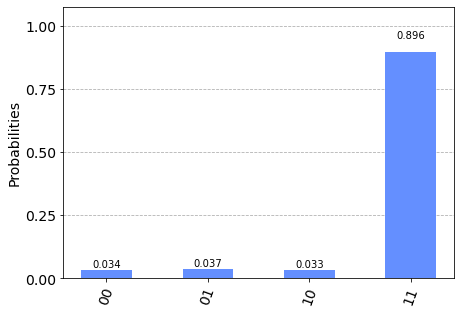

In [7]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator, shots=10000).result().get_counts()
plot_histogram(counts)

## Look at the performance on the real machine

In [1]:
# Load IBMQ Account and choose a real backend
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmq_belem'
backend = provider.get_backend(name)

In [12]:
# Transile the circuit to see what the actual circuit that can run on the real device
circ_trans = transpile(qc, backend, layout_method = "noise_adaptive", optimization_level=0) # Optimization level from 0 to 3, short circuit depth
print("Circuit Depth is {:d}".format(circ_trans.depth()))
job = execute(circ_trans, backend=backend, shots=8192, optimization_level=0)
job_monitor(job)

Circuit Depth is 40
Job Status: job has successfully run


6077eb4226eae1ff206f8fae


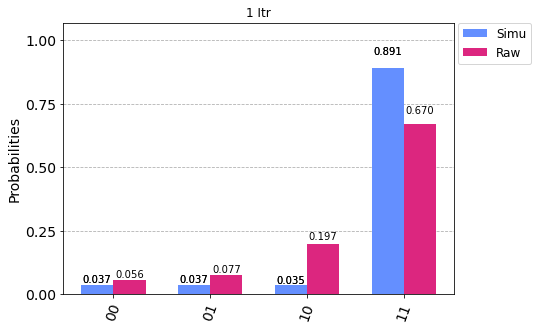

In [13]:
print(job.job_id())
simu_counts = execute(circ_trans, backend=Aer.get_backend('qasm_simulator'), shots=8192).result().get_counts()
real_counts = job.result().get_counts()
plot_histogram([simu_counts, real_counts], legend=['Simu', 'Raw'], title='1 Itr')

In [23]:
def FP_Grover_unitary(n, indices_to_mark, itr, d, return_params = False):
    # Compute the rest of parameters
    l = itr
    L = 2*l+1

    gamma_inverse = Chbshv_poly(1/L, 1/d)
    omega = 1 - Chbshv_poly(1/L, 1/d)**(-2)

    alpha =  mpm.zeros(1,l)
    beta = mpm.zeros(1,l)
    for i in range(l): # use i instead of j since python use 1j for sqrt(-1)
        alpha[i] = 2*mpm.acot(mpm.tan(2*mpm.pi*(i+1)/L) * mpm.sqrt(1-1/gamma_inverse**2))
        beta[l-(i+1)+1-1] = -alpha[i]

    # Convert to numpy
    gamma_inverse = np.array([gamma_inverse], dtype=complex)[0]
    omega = np.array([omega], dtype=complex)[0]
    alpha = np.array(alpha.tolist()[0], dtype=complex)
    beta = np.array(beta.tolist()[0], dtype=complex)
    
    # Prepare vectors
    # Start with |0...0> as default to many quantum computing platforms
    ket0 = np.zeros((2**n, 1))
    ket0[0] = 1

    # Initilize the state with matrix A, where |s> = A|0...0>
    A = Hn(n) # Use H^{\otimes n} to initilize the state
    kets = np.dot(A, ket0) #Compute |s>

    # Compute |t>, the target state
    kett = np.zeros((2**n, 1))
    kett[indices_to_mark] = 1 

    r = QuantumRegister(n)
    qc = QuantumCircuit(r)
    for i in range(n):
        qc.h(i)
    for i in range(itr):
        a = alpha[i] # selected alpha
        b = beta[i] # selected beta

        Sbeta = In(n) - (1-np.exp(1j*b))*np.dot(kett,kett.T)
        qc.unitary(Operator(Sbeta), range(n))
        Salpha = In(n) - (1-np.exp(-1j*a))*np.dot(kets,kets.T)
        qc.unitary(Operator(Salpha), range(n))
        
    if return_params:
        return qc, (gamma_inverse, 1/2**n, omega, alpha, beta)
    else:
        return qc

In [24]:
itr = 2
unitary_qc2 = FP_Grover_unitary(n, indices_to_mark, itr, d, return_params = False)
unitary_qc2.measure_all()

# Transile the circuit to see what the actual circuit that can run on the real device
circ_trans2 = transpile(unitary_qc2, backend, layout_method = "noise_adaptive", optimization_level=0) # Optimization level from 0 to 3, short circuit depth
print("Circuit Depth is {:d}".format(circ_trans2.depth()))
job2 = execute(circ_trans2, backend=backend, shots=8192, optimization_level=0)
job_monitor(job2)

Circuit Depth is 74
Job Status: job has successfully run


In [25]:
circ_trans2.draw()

global phase: -5.7716
                                                                           »
ancilla_0 -> 0 ────────────────────────────────────────────────────────────»
                                                                           »
ancilla_1 -> 1 ────────────────────────────────────────────────────────────»
                                                                           »
ancilla_2 -> 2 ────────────────────────────────────────────────────────────»
               ┌───────┐┌────┐┌──────────┐┌────┐┌────────┐┌─────────┐┌────┐»
   q108_1 -> 3 ┤ RZ(π) ├┤ √X ├┤ RZ(3π/2) ├┤ √X ├┤ RZ(3π) ├┤ RZ(0.0) ├┤ √X ├»
               ├───────┤├────┤├──────────┤├────┤├────────┤├─────────┤├────┤»
   q108_0 -> 4 ┤ RZ(π) ├┤ √X ├┤ RZ(3π/2) ├┤ √X ├┤ RZ(3π) ├┤ RZ(0.0) ├┤ √X ├»
               └───────┘└────┘└──────────┘└────┘└────────┘└─────────┘└────┘»
       meas: 2/════════════════════════════════════════════════════════════»
                                                                           »
«                                                                           »
«ancilla_0 -> 0 ────────────────────────────────────────────────────────────»
«                                                                           »
«ancilla_1 -> 1 ────────────────────────────────────────────────────────────»
«                                                                           »
«ancilla_2 -> 2 ────────────────────────────────────────────────────────────»
«               ┌──────────┐┌────┐┌──────────┐┌───┐       ┌─────────┐       »
«   q108_1 -> 3 ┤ RZ(3π/2) ├┤ √X ├┤ RZ(5π/2) ├┤ X ├───────┤ RZ(π/2) ├───────»
«               └┬────────┬┘├────┤└┬────────┬┘└─┬─┘┌──────┴─────────┴──────┐»
«   q108_0 -> 4 ─┤ RZ(2π) ├─┤ √X ├─┤ RZ(3π) ├───■──┤ RZ(0.192835807949161) ├»
«                └────────┘ └────┘ └────────┘      └───────────────────────┘»
«       meas: 2/════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                    »
«ancilla_0 -> 0 ─────────────────────────────────────────────────────»
«                                                                    »
«ancilla_1 -> 1 ─────────────────────────────────────────────────────»
«                                                                    »
«ancilla_2 -> 2 ─────────────────────────────────────────────────────»
«               ┌────┐┌──────────┐┌────┐┌──────────────────────┐┌───┐»
«   q108_1 -> 3 ┤ √X ├┤ RZ(3π/2) ├┤ √X ├┤ RZ(12.7677355292747) ├┤ X ├»
«               ├────┤└┬────────┬┘├────┤├──────────────────────┤└─┬─┘»
«   q108_0 -> 4 ┤ √X ├─┤ RZ(2π) ├─┤ √X ├┤ RZ(14.3300027491032) ├──■──»
«               └────┘ └────────┘ └────┘└──────────────────────┘     »
«       meas: 2/═════════════════════════════════════════════════════»
«                                                                    »
«                                                            »
«ancilla_0 -> 0 ─────────────────────────────────────────────»
«                                                            »
«ancilla_1 -> 1 ─────────────────────────────────────────────»
«                                                            »
«ancilla_2 -> 2 ─────────────────────────────────────────────»
«               ┌──────────────────────┐┌────┐┌───────┐┌────┐»
«   q108_1 -> 3 ┤ RZ(1.47011386933715) ├┤ √X ├┤ RZ(π) ├┤ √X ├»
«               ├──────────────────────┤├────┤├───────┤├────┤»
«   q108_0 -> 4 ┤ RZ(3.09125142486092) ├┤ √X ├┤ RZ(π) ├┤ √X ├»
«               └──────────────────────┘└────┘└───────┘└────┘»
«       meas: 2/═════════════════════════════════════════════»
«                                                            »
«                                                                          »
«ancilla_0 -> 0 ───────────────────────────────────────────────────────────»
«                                                                  

6077caa865fc99dfebd7f71d


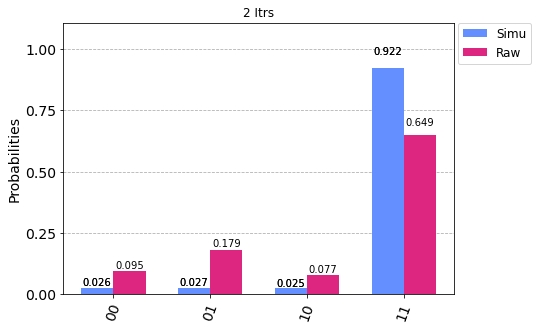

In [38]:
print(job2.job_id())
simu_counts2 = execute(circ_trans2, backend=Aer.get_backend('qasm_simulator'), shots=8192).result().get_counts()
real_counts2 = job2.result().get_counts()
plot_histogram([simu_counts2, real_counts2], legend=['Simu', 'Raw'], title='2 Itrs')

In [27]:
itr = 3
unitary_qc3 = FP_Grover_unitary(n, indices_to_mark, itr, d, return_params = False)
unitary_qc3.measure_all()

# Transile the circuit to see what the actual circuit that can run on the real device
circ_trans3 = transpile(unitary_qc3, backend, layout_method = "noise_adaptive", optimization_level=0) # Optimization level from 0 to 3, short circuit depth
print("Circuit Depth is {:d}".format(circ_trans3.depth()))
job3 = execute(circ_trans3, backend=backend, shots=8192, optimization_level=0)
job_monitor(job3)

Circuit Depth is 108
Job Status: job has successfully run


6077cb1365fc994200d7f723


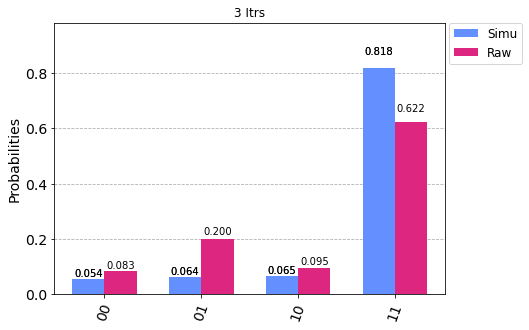

In [37]:
print(job3.job_id())
simu_counts3 = execute(circ_trans3, backend=Aer.get_backend('qasm_simulator'), shots=8192).result().get_counts()
plot_histogram([simu_counts3,job3.result().get_counts()], legend=['Simu', 'Raw'], title='3 Itrs')

In [36]:
itr = 4
unitary_qc4 = FP_Grover_unitary(n, indices_to_mark, itr, d, return_params = False)
unitary_qc4.measure_all()

# Transile the circuit to see what the actual circuit that can run on the real device
circ_trans4 = transpile(unitary_qc4, backend, layout_method = "noise_adaptive", optimization_level=0) # Optimization level from 0 to 3, short circuit depth
print("Circuit Depth is {:d}".format(circ_trans4.depth()))
job4 = execute(circ_trans4, backend=backend, shots=8192, optimization_level=0)
job_monitor(job4)

Circuit Depth is 142
Job Status: job has successfully run


6077d0ef2d58d01dbf21cb44


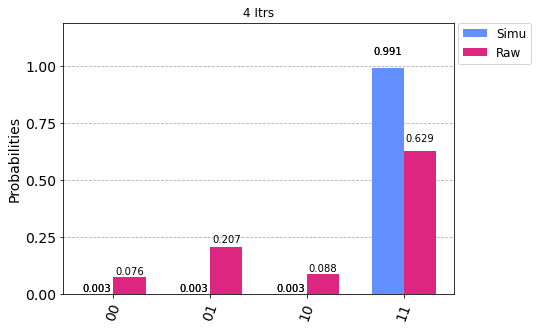

In [40]:
print(job4.job_id())
simu_counts4 = execute(circ_trans4, backend=Aer.get_backend('qasm_simulator'), shots=8192).result().get_counts()
plot_histogram([simu_counts4,job4.result().get_counts()], legend=['Simu', 'Raw'], title='4 Itrs')